#          MIDTERM PROJECT

# EMPLOYEE DEPARTURE PREDICITON USING MACHINE LEARNING


TEAM:PRANAV,NAVEEN

- This project focuses on developing and evaluating machine learning models for predicting employee departure or churn. The dataset contains crucial employee information such as gender, distance from the office, years of experience, salary details, and performance reviews. The main objective is to build accurate classification models that can predict whether an employee will leave the company or not based on these attributes. By leveraging machine learning algorithms and evaluating model performance.

- Target: Left



- Data Description:
- Unnamed0: index
- RecordID: unique value of each individual employee (identifier).
- Gender: Male/Female
- Distance: Distance from the premisis.
- YearsWorked: Number of years with the organisation. 
- Previous Salary: salary earlier
- Salary: Current salary.
- SelfReview: Self rating
- Supervisor Review: Supervisor Rating 
- Department Code: Department the employee belongs 
- Left: Whether the employee stayed or left the organisation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# Exploratory Data Analysis

In [2]:
#load the data
df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/midterm/employee_departure_dataset.csv')
df.head()

,Unnamed: 0,RecordId,Gender,Distance,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left
0,0,1002332,1,>30miles,10,63K,65K,4.0,5.0,2,0
1,1,1002333,0,~10miles,7,54K,56K,4.0,4.0,2,0
2,2,1002334,0,<5mile,5,60K,61K,4.0,4.0,3,0
3,3,1002335,0,~15miles,4,59K,60K,5.0,5.0,7,0
4,4,1002336,1,~20miles,6,61K,63K,5.0,5.0,5,0


In [3]:
#Drop columns that are sequential
columns_to_drop = ["Unnamed: 0", "RecordId"]
df.drop(columns=columns_to_drop, inplace=True)

In [4]:
#check Data types
df.dtypes

Gender                int64
Distance             object
YearsWorked           int64
PreviousSalary       object
Salary               object
SelfReview          float64
SupervisorReview    float64
DepartmentCode        int64
Left                  int64
dtype: object

In [5]:
#convert the salary columns into a useful format
df['PreviousSalary'] = df['PreviousSalary'].astype(str).str.replace('K', '').astype(float) * 1000
df['Salary'] = df['Salary'].astype(str).str.replace('K', '').astype(float) * 1000

In [6]:
df['Salary_Change']=df['Salary']-df['PreviousSalary']

In [7]:
bins = [0,3,7,10,14]
labels = ['Fresher', 'Indermediate','Senior', 'Experienced']
df['ExperienceLevel'] = pd.cut(df['YearsWorked'], bins=bins, labels=labels)

In [8]:
df.dtypes

Gender                 int64
Distance              object
YearsWorked            int64
PreviousSalary       float64
Salary               float64
SelfReview           float64
SupervisorReview     float64
DepartmentCode         int64
Left                   int64
Salary_Change        float64
ExperienceLevel     category
dtype: object

In [9]:
#check number of unique values
df.nunique()

Gender               2
Distance             5
YearsWorked         15
PreviousSalary      26
Salary              30
SelfReview           3
SupervisorReview     4
DepartmentCode       6
Left                 2
Salary_Change        7
ExperienceLevel      4
dtype: int64

In [10]:
#check null values
df.isna().sum()

Gender                0
Distance            265
YearsWorked           0
PreviousSalary        0
Salary                0
SelfReview          584
SupervisorReview    576
DepartmentCode        0
Left                  0
Salary_Change         0
ExperienceLevel      14
dtype: int64

In [11]:
df.head()

,Gender,Distance,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left,Salary_Change,ExperienceLevel
0,1,>30miles,10,63000.0,65000.0,4.0,5.0,2,0,2000.0,Senior
1,0,~10miles,7,54000.0,56000.0,4.0,4.0,2,0,2000.0,Indermediate
2,0,<5mile,5,60000.0,61000.0,4.0,4.0,3,0,1000.0,Indermediate
3,0,~15miles,4,59000.0,60000.0,5.0,5.0,7,0,1000.0,Indermediate
4,1,~20miles,6,61000.0,63000.0,5.0,5.0,5,0,2000.0,Indermediate


In [12]:
df.describe()

,Gender,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left,Salary_Change
count,300000.000000,300000.000000,300000.000000,300000.000000,299416.000000,299424.000000,300000.000000,300000.000000,300000.000000
mean,0.401043,7.003120,59505.056667,61309.390000,4.399084,4.101308,3.997480,0.231833,1804.333333
std,0.490111,1.867817,2988.773027,3171.111479,0.663330,0.943972,2.161085,0.422004,849.456862
min,0.000000,0.000000,45000.000000,45000.000000,3.000000,2.000000,1.000000,0.000000,0.000000
25%,0.000000,6.000000,58000.000000,59000.000000,4.000000,4.000000,2.000000,0.000000,1000.000000
50%,0.000000,7.000000,60000.000000,61000.000000,4.000000,4.000000,3.000000,0.000000,2000.000000
75%,1.000000,8.000000,62000.000000,63000.000000,5.000000,5.000000,6.000000,0.000000,2000.000000
max,1.000000,14.000000,70000.000000,74000.000000,5.000000,5.000000,7.000000,1.000000,6000.000000


In [13]:
#to check correlations between years worked, salaries, review scores, and whether an employee has left.
df.corr()

C:\Users\gsspr\AppData\Local\Temp\ipykernel_34932\982702872.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Gender,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Left,Salary_Change
Gender,1.000000,-0.000103,0.002419,0.002525,-0.000466,-0.002540,0.000246,-0.080043,0.000915
YearsWorked,-0.000103,1.000000,0.000206,-0.000033,-0.000260,0.002250,0.000805,-0.060786,-0.000846
PreviousSalary,0.002419,0.000206,1.000000,0.963687,0.000957,0.001806,0.002340,-0.012598,0.079093
Salary,0.002525,-0.000033,0.963687,1.000000,0.001280,0.001048,0.002938,-0.076938,0.342418
SelfReview,-0.000466,-0.000260,0.000957,0.001280,1.000000,0.000693,-0.000314,0.157590,0.001411
SupervisorReview,-0.002540,0.002250,0.001806,0.001048,0.000693,1.000000,-0.002264,-0.249545,-0.002443
DepartmentCode,0.000246,0.000805,0.002340,0.002938,-0.000314,-0.002264,1.000000,-0.216110,0.002735
Left,-0.080043,-0.060786,-0.012598,-0.076938,0.157590,-0.249545,-0.216110,1.000000,-0.242895
Salary_Change,0.000915,-0.000846,0.079093,0.342418,0.001411,-0.002443,0.002735,-0.242895,1.000000


C:\Users\gsspr\AppData\Local\Temp\ipykernel_27952\2948105825.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


                    Gender  YearsWorked  PreviousSalary    Salary  SelfReview  \
Gender            1.000000    -0.000103        0.002419  0.002525   -0.000466   
YearsWorked      -0.000103     1.000000        0.000206 -0.000033   -0.000260   
PreviousSalary    0.002419     0.000206        1.000000  0.963687    0.000957   
Salary            0.002525    -0.000033        0.963687  1.000000    0.001280   
SelfReview       -0.000466    -0.000260        0.000957  0.001280    1.000000   
SupervisorReview -0.002540     0.002250        0.001806  0.001048    0.000693   
DepartmentCode    0.000246     0.000805        0.002340  0.002938   -0.000314   
Left             -0.080043    -0.060786       -0.012598 -0.076938    0.157590   
Salary_Change     0.000915    -0.000846        0.079093  0.342418    0.001411   

                  SupervisorReview  DepartmentCode      Left  Salary_Change  
Gender                   -0.002540        0.000246 -0.080043       0.000915  
YearsWorked               0.00225

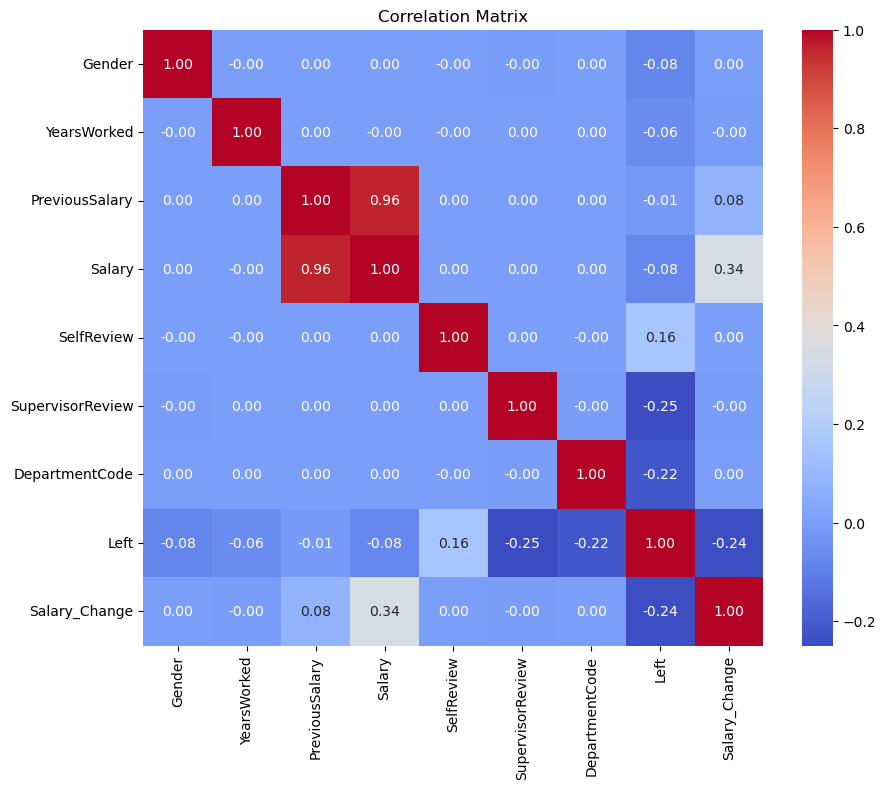

In [41]:
correlation_matrix = df.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


- A weak negative correlation (-0.22) between certain departments and employee attrition suggests that those departments may have higher turnover rates.
- Employees with lower self-review ratings are somewhat more likely to leave the company (correlation of 0.16).
- Employees with lower supervisor review ratings are even more likely to leave the company (correlation of -0.25).





In [14]:
#Distribution check
y=df['Left']
t=[i for i in df if i!='Left']
X=df[t]

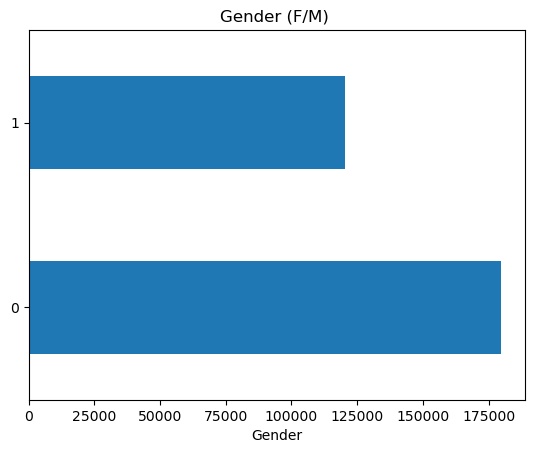

In [44]:
X['Gender'].value_counts().plot.barh()
plt.title('Gender (F/M) ')
plt.xlabel('Gender')
plt.show()

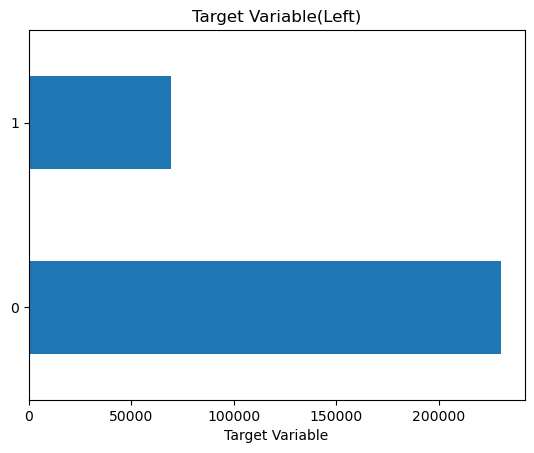

In [43]:
y.value_counts().plot.barh()
plt.title('Target Variable(Left)')
plt.xlabel('Target Variable')
plt.show()

(-8.0, 20.0)

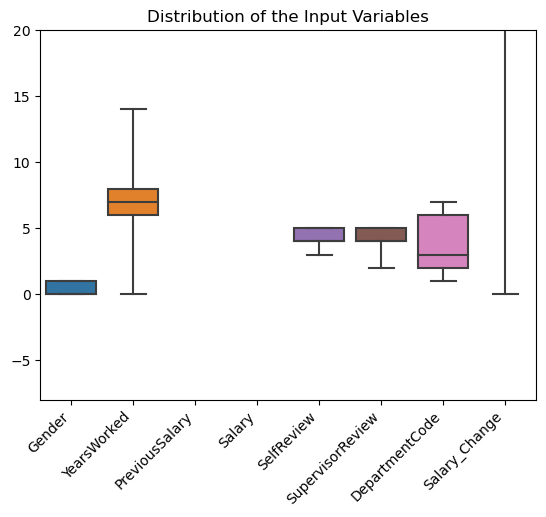

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
ax=sns.boxplot(X,whis=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of the Input Variables')
plt.ylim(-8, 20)

Text(0.5, 1.0, 'Distribution of the Input Variables')

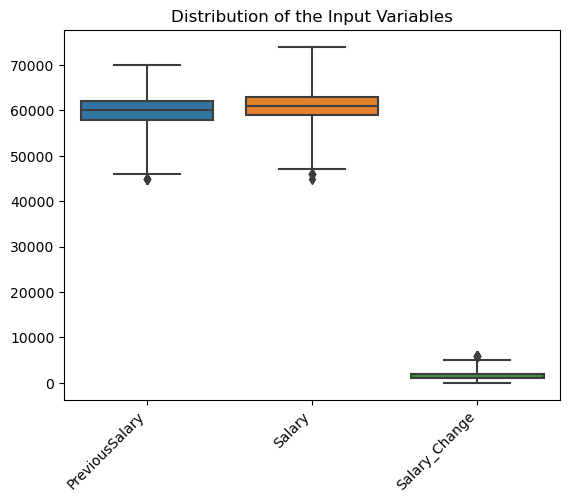

In [46]:
a=['PreviousSalary','Salary','Salary_Change']
ax=sns.boxplot(X[a],whis=3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Distribution of the Input Variables')

In [19]:
X.head()

,Gender,Distance,YearsWorked,PreviousSalary,Salary,SelfReview,SupervisorReview,DepartmentCode,Salary_Change,ExperienceLevel
0,1,>30miles,10,63000.0,65000.0,4.0,5.0,2,2000.0,Senior
1,0,~10miles,7,54000.0,56000.0,4.0,4.0,2,2000.0,Indermediate
2,0,<5mile,5,60000.0,61000.0,4.0,4.0,3,1000.0,Indermediate
3,0,~15miles,4,59000.0,60000.0,5.0,5.0,7,1000.0,Indermediate
4,1,~20miles,6,61000.0,63000.0,5.0,5.0,5,2000.0,Indermediate


## Observations:

- The output variable is not a perfectly balanced one.
- The gender is also not balanced.
- salary columns are not in correct format.
- There are unnecessary columns in the data which are sequential and are of no use.
- Few variables like salary can be converted to numerical which can be more helpful to identify patterns.
- There is not much variance in most of the independent variables.
- the highest correlation is found between previous salary and the salary.
- gender and years worked show least correlation with all the other features.
- a few outilers are found in the salary columns.

## Operations Performed:

- Salary columns are converted into exact numerical figures which can be useful for the analysis.
- Feature engineering is performed and 2 new features are extracted. Experience level is brought in which basically segments the total data into 4 different categories. Salary difference is brought in to see if it has any impact on the target variable.
- Class dirtribution is observed using the horizontal bar plots.
- Outliers are observed using box plots.

## Game Plan:

- Missing values are found so we use imputer for numerical variables, onehotencoder for categorical variables.
- standard scaler will be implemented to scale and bring all the values to a single platform.
- We will be implementing 3 models, as it is a classification problem we implemented logistic regression, decision tree and random forest methods and select the best model(winner model).
- As it is a large dataset, implementing this on the entire thing is not feesible. We will be doing it on a sample of data and then select the winner model and implement it on the entire dataset.
- we will select a range of hyper parameters for the model.
- We will employ GridSearch for identifying the best metrics and then use them on the final model.
- As it is an imbalanced dataset, we will not consider accuracy as a metric as it can be mis-leading. Selecting the metric depends on the importance of false positives and false negatives.  In such cases, ROC-AUC, F1 score, or Precision-Recall AUC provide a more nuanced evaluation of model performance across classes.
- Here we are considering Precision-recall AUC as it will perfectly balance both, employees likely to leave (recall) and maintaining precision. 

# Modeling

## Pipeline Creation:

In [20]:
# create processing pipeline
num=['YearsWorked','PreviousSalary','Salary','SelfReview','SupervisorReview','Salary_Change']
cat=['Gender','Distance','DepartmentCode','ExperienceLevel']
#num pipeline
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),('standardize_num', StandardScaler())])
#cat pipeline
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

processing_pipeline = ColumnTransformer(transformers=[('num pipeline', num_pipeline, num),
                                                      ('cat pipeline', cat_pipeline, cat)])
processing_pipeline

ColumnTransformer(transformers=[('num pipeline',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['YearsWorked', 'PreviousSalary', 'Salary',
                                  'SelfReview', 'SupervisorReview',
                                  'Salary_Change']),
                                ('cat pipeline',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Gender', 'Distance', 'DepartmentCode',
                                  'ExperienceLevel'])])

In [21]:
X_sample=X[0:10000]
y_sample=y[0:10000]

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sample,
                                                        y_sample,
                                                        test_size=0.20)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

Training examples: 8,000
Test examples: 2,000


# Logistic Regression

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



# logistic regression pipeline 
logreg_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))  
])

# parameter grid for logistic regression 
logreg_param_grid = [{
    'logreg__class_weight': [None, 'balanced'],  
    'logreg__C': [0.01, 0.1, 1, 10, 100],  
    'logreg__penalty': ['l1', 'l2']  
}]

# Scoring metric
scoring = 'f1'

# GridSearch
logreg_gc = GridSearchCV(estimator=logreg_modeling_pipeline, param_grid=logreg_param_grid, cv=5, scoring=scoring)

# Fit the model on the training data
logreg_gcv_results = logreg_gc.fit(X_train, y_train)

In [24]:
logreg_gc.best_params_

{'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l1'}

In [25]:
logreg_gc.score(X_train, y_train)

0.6049351389175838

In [26]:
logreg_gc.score(X_test, y_test)

0.6592604477977161

# Decision Tree

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


# Define the Decision Tree modeling pipeline
dt_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('dt', DecisionTreeClassifier(random_state=42))  # Using 'dt' for DecisionTreeClassifier
])

dt_param_grid = [{
    'dt__criterion': ['gini'],  
    'dt__max_depth': [ 5, 7, 10],  
    'dt__min_samples_leaf': [30, 50, 70],  
    'dt__min_samples_split': [20, 40, 60]  
}]
# scoring metric
scoring = 'f1'

# Configure GridSearch
dt_gc = GridSearchCV(estimator=dt_modeling_pipeline, param_grid=dt_param_grid, cv=5, scoring=scoring)

# Fit the model on the training data
dt_gcv_results = dt_gc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [28]:
dt_gcv_results.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 10,
 'dt__min_samples_leaf': 50,
 'dt__min_samples_split': 20}

In [29]:
dt_gcv_results.score(X_train, y_train)

0.7819766705198528

In [30]:
dt_gcv_results.score(X_test, y_test)

0.7604327399516789

# Random Forests

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# Define the Random Forest modeling pipeline
rf_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('rf', RandomForestClassifier(random_state=42))  # 'rf' for RandomForestClassifier
])

# Define the parameter grid focusing on the specified essential parameters

rf_param_grid = [{
    'rf__criterion': ['gini'],  
    'rf__max_depth': [5, 10],  
    'rf__n_estimators': [30, 50],  
    'rf__class_weight': ['balanced'],  
    'rf__max_samples': [None]  
}]

#Scoring metric
scoring = 'f1'

# Configure GridSearch
rf_gc = GridSearchCV(estimator=rf_modeling_pipeline, param_grid=rf_param_grid, cv=5, scoring=scoring)

# Fit the model on the training data
rf_gcv_results = rf_gc.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [32]:
rf_gcv_results.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': 10,
 'rf__max_samples': None,
 'rf__n_estimators': 50}

In [33]:
rf_gcv_results.score(X_train, y_train)

0.8803408285063584

In [34]:
rf_gcv_results.score(X_test, y_test)

0.7338818299198892

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

best_modeling_pipeline = Pipeline([
    ('data_processing', processing_pipeline),
    ('ml', DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=70,min_samples_split=20))]
)
best_modeling_pipeline

Training examples: 240,000
Test examples: 60,000


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num pipeline',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['YearsWorked',
                                                   'PreviousSalary', 'Salary',
                                                   'SelfReview',
                                                   'SupervisorReview',
                                                   'Salary_Change']),
                                                 ('cat pipeline',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Gender', 'Distance',
                                                   'DepartmentCode',
                                                   'ExperienceLevel'])])),
                ('ml',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=70,
                                        min_samples_split=20))])

In [36]:
from sklearn.metrics import classification_report

best_modeling_pipeline.fit(X_train, y_train)
y_pred = best_modeling_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     46190
           1       0.68      0.91      0.78     13810

    accuracy                           0.88     60000
   macro avg       0.82      0.89      0.85     60000
weighted avg       0.90      0.88      0.89     60000



Conclusion: In this project, we evaluated three different machine learning models - Logistic Regression, Decision Trees, and Random Forest - to address our classification problem, with a focus on optimizing the F1 score as our primary metric due to its relevance in balancing precision and recall, particularly important in the context of our dataset's characteristics.

The performance of the models, as measured by the F1 score, varied, indicating different levels of suitability for our task:

Logistic Regression showed the least variance between training (0.61) and testing (0.65) F1 scores, suggesting good generalization but overall lower performance compared to the other models.
Decision Trees yielded F1 scores of 0.78 (train) and 0.76 (test), demonstrating a slightly better balance between precision and recall than Logistic Regression and exhibiting modest overfitting.
Random Forest achieved the highest F1 scores among the evaluated models, with 0.88 (train) and 0.78 (test), indicating a strong performance on the training data but also the most significant overfitting.
Given these results, the Decision Tree model was chosen for its favorable balance between training and testing performance, suggesting it as the most suitable model among those tested. This model provides a good starting point for our classification task, offering a reasonable trade-off between simplicity, interpretability, and predictive power.

Future Work:
- Work on future engineering with caution(considering complexity).
- Adjust the hyper parameters.